## Chapter 3: Classification

In the previous chapter we analyzed an example of supervised learning for a regression task.
The second most common supervised learning task is classification, and we'll check that here.

To do so, we'll use the [MNIST](https://docs.ultralytics.com/fr/datasets/classify/mnist/) dataset of handwritten characters, and try to create a model able to match these, with the characters they actually represent.

In [161]:
# Fetch the dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [164]:
mnist["data"].shape # (70000, 784), 70 000 images of 28px x 28 px (each feature is a pixel)

(70000, 784)

In [165]:
mnist["target"].shape # (70000,)

(70000,)

In [166]:
X, y = mnist['data'], mnist['target']

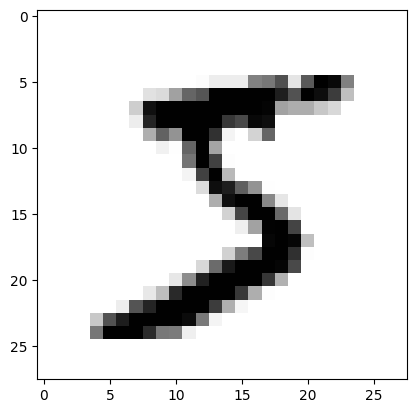

In [310]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0,:]
def plot_digit(digit):
    some_digit_image = digit.values.reshape(28,28)
    plt.imshow(some_digit_image, cmap='binary')

plot_digit(some_digit)

In [180]:
# looks like a '5', or maybe a 's'? Label tells us it's a '5'
y[0]

'5'

In [197]:
# This dataset is already properly split (firs 60k for training, last 10k for testing)
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y[:60000], y[60000:]

In [219]:
# As an exercise, let's try to simply train a binary classifier : return True if a '5' is detected, False otherwise

from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [220]:
sgd_clf.predict(X_train.iloc[0:1,:])

array([ True])

In [226]:
# implement custom cross-validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    correct_percent = sum(y_pred == y_test_fold) / len(y_pred)
    print(correct_percent)    

0.95035
0.96035
0.9604


In [232]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [235]:
# Score looks good... But is it really, let's see :

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)

nvr_5_clf = Never5Classifier()
cross_val_score(nvr_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [239]:
"""
A better way to evaluate classifiers is to use a confusion matrix :
Check how many times a item of class A gets classified as class B

In our case, how many times a non-5 is true and a 5 is false
"""

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

"""
This function works like cross_val_score, but instead returns the predictions made.
That way we get "clean" prediction, as we are sure that the prediction for each entry, is made by a model that was not trained on this entry
(because of the fold mechanism)
"""


array([[53892,   687],
       [ 1891,  3530]])

In [242]:

from sklearn.metrics import confusion_matrix

"""
Each row is an actual class, each columns is a predicted class

first row considers the negative-class (non-5s)
Second row considers the positive-class (5s)
First column are the items predicted as non-5
Second  columns are the items predicted as 5

so we have : 
- 50k+ non-5, predicted as non 5 (TN)
- ~ 1000 non-5, predicted as 5 (FP)
- 1891 5 predicted as non-5 (FN)
- 3000+ 5 predicted as 5 (TP)
"""

conf_matrix = confusion_matrix(y_train_5, y_train_pred)

(2, 2)

In [243]:
# let's compute the _precision_ : true positive / (true positive + false positive)
# High precision may involve many false negative, we miss some positive cases
true_pos = conf_matrix[1][1]
false_pos = conf_matrix[0][1]

precision = true_pos / (true_pos + false_pos)
precision

np.float64(0.8370879772350012)

In [248]:
# let's compute the _recall_ or _sensitivity_ : true positive / (true positive + false negative)
# High recall may involve many false positive, we may have too many positives

false_neg = conf_matrix[1][0]

recall = true_pos / (true_pos + false_neg)
recall

np.float64(0.6511713705958311)

In [250]:
# F1 score is used to combine both : F1 = 2 * ((precision * recall) / (precision + recall))
# F1 score favor models that have balanced precisions and recall, sometimes you may favor one 
# For instance, for cancer detection, we may want prefer high recall over high f1

f1 = 2 * ((precision * recall)/(precision + recall))
f1

np.float64(0.7325171197343846)

In [251]:
# Could as well be done directly with sklearn
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)
f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Precision/Recall trade-off

Increasing _precision_ will reduce recall, and increasing _recall_ will reduce precision.
As long as our system is not 100% accurate, errors will either be false positive, or false negative... Impacting one or the other of precision and recall.

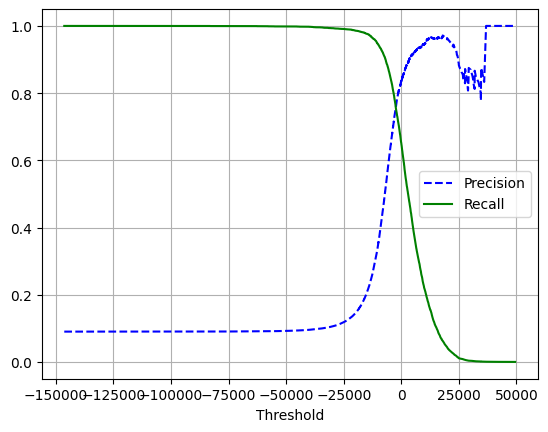

In [257]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend()
    plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC Curve

The Receiver Operating Characteristic (ROC) curve, is a common way to evaluate classifiers.
it uses the **True positive rate** (another name for recall) against the **False positive rate**. 

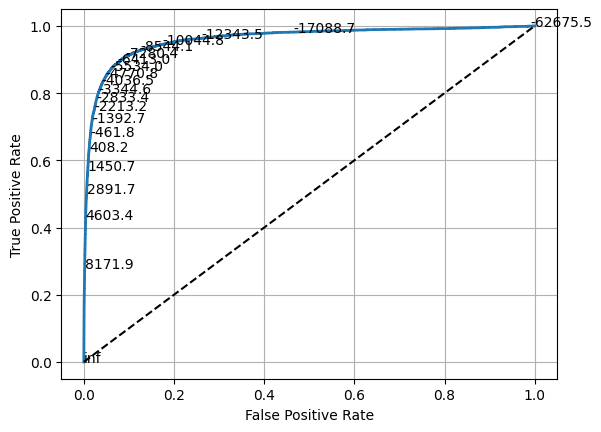

In [265]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    if label:
        plt.legend()
    # Annotate thresholds every ~50 points to avoid clutter
    for i in range(0, len(thresholds), max(1, len(thresholds) // 20)):
        plt.annotate(f"{thresholds[i]:.1f}", (fpr[i], tpr[i]))
plot_roc_curve(fpr, tpr)

In [266]:
# One way to compare to type of classifiers is to compare the area under the ROC curve (AUC) 
# A perfect classifier has 1.0 AUC, a random one has 0.5

### MULTICLASS CLASSIFICATION

In [268]:
# We can still use binary classifiers 
# For N classes :
# One-vs-Rest (OVR) - N classifiers, 1 for each class
# One-vs-One (OVO) - N x (N - 1) / 2 classifiers, one for each pair of values.

"""
Sklearn detects when you try to run a binary classifier for a multiclass classification task, 
and it automatically runs OVR or OVO.
For example with SVC it runs OVO :
https://scikit-learn.org/0.21/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
"""

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array(['5'], dtype=object)

In [269]:
# We can see that we'll get 10 scores per instance (one per class)
# internally, 45 models were trained, and the prediction is based on the one that won the most duels
svm_clf.decision_function([some_digit])

/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [270]:
"""
You can force sklearn to use OvO or OvR by using :
"""


from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/c

array(['5'], dtype='<U1')

In [271]:
# but we can also use a SGDCClassifier (or RandomForestClassifier) that are not binary

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/Users/charles/Library/Caches/pypoetry/virtualenvs/jupyter-book-u4PKAdXK-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array(['3'], dtype='<U1')

In [277]:
# We can also try feature scaling :

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_prepared = std_scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error analysis

In [278]:
y_train_pred = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

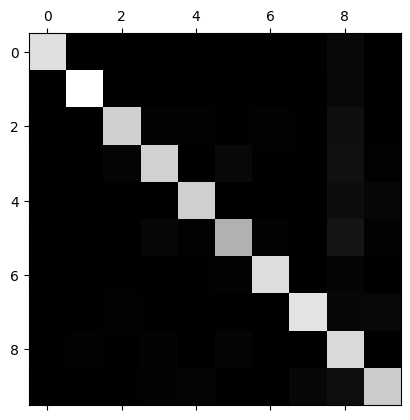

In [280]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

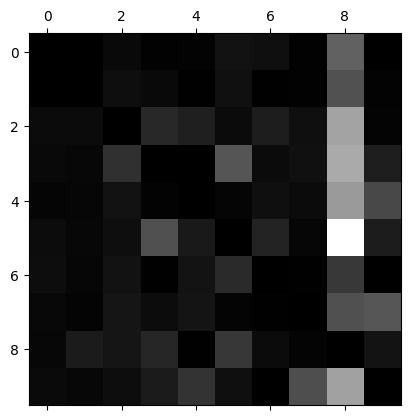

In [302]:
# Let's show only the errors 

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

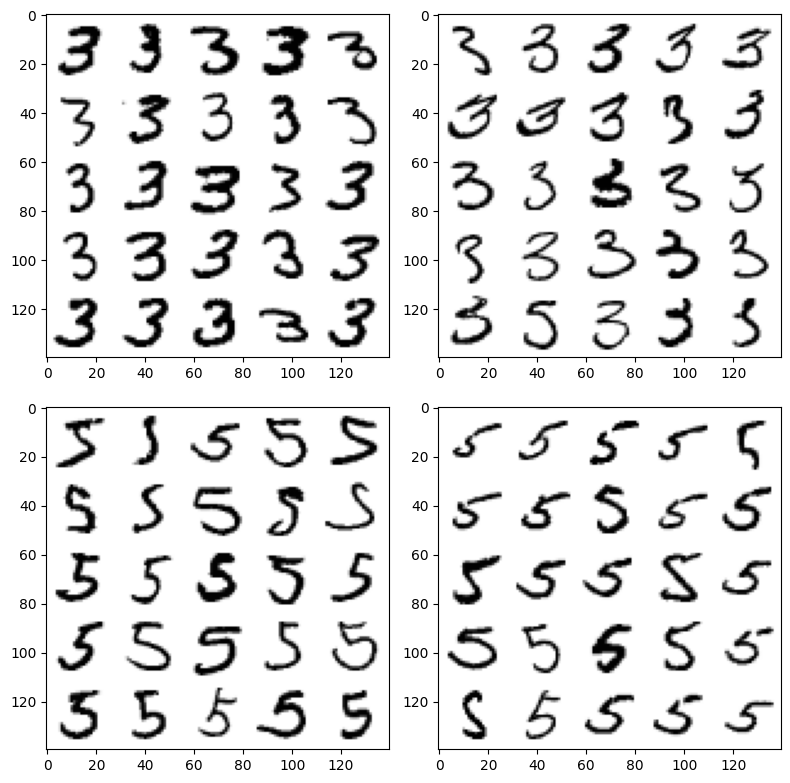

In [317]:
cl_3, cl_5 = '3', '5'
X_33 = X_train[(y_train == cl_3) & (y_train_pred == cl_3)]
X_35 = X_train[(y_train == cl_3) & (y_train_pred == cl_5)]
X_53 = X_train[(y_train == cl_5) & (y_train_pred == cl_3)]
X_55 = X_train[(y_train == cl_5) & (y_train_pred == cl_5)]

"""
some_digit = X.iloc[0,:]
def plot_digit(digit):
    some_digit_image = digit.values.reshape(28,28)
    plt.imshow(some_digit_image, cmap='binary') 
"""

def plot_digits(instances, images_per_row=10, **options):
    if len(instances) == 0:
        print("No instances to display.")
        return
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)


plt.figure(figsize=(8,8))

plt.subplot(221)
plot_digits(X_33[:25], images_per_row=5)

plt.subplot(222)
plot_digits(X_35[:25], images_per_row=5)

plt.subplot(223)
plot_digits(X_53[:25], images_per_row=5)

plt.subplot(224)
plot_digits(X_55[:25], images_per_row=5)

plt.tight_layout()
plt.show()


We can see that, even though 8 are successfully classified, a lot of instances are poorly identified as 8
Also we can see that a lot of 5 are identified as 3s
And a lot of 3s are identified as 5s

### Multilabel classification

In some cases you may want you classifier to return not 1, but multiple classes : for instance if it recognized multiple faces on a picture.
In our case, we may want our classifier to identify "large numbers" and "odd numbers".

In [295]:
from sklearn.neighbors import KNeighborsClassifier

y_train_int = y_train.astype(int)

y_train_large = (y_train_int >= 7)
y_train_odd = (y_train_int % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [298]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

### Multioutput classification

For instance, a model to remove noise from images.
In the previous example, we have multiple output label, but each of them could only be of one class.
Here, each output label may take a value between 0 and 255

In [ ]:
# let's create the dataset by adding noise

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mode = X_test

knn_clf.fit(X_train_mod, y_train_mod)
# clean_digit = knn_clf([X_test_mod[some_index]])
# plot_digit(clean_digit)